# Identify spikes
Develop algorithm for identifying spikes (action potential-like activity)

## Set-up

### Imports

In [1]:
# imports - general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# imports - custom
import sys
sys.path.append("../code")
from info import FS, N_CHANNELS#, N_SPECIES
from epoch_extraction_tools import get_epochs, plot_epochs, get_epoch_times

# autoreload
%load_ext autoreload
%autoreload 2

## Main

### Load data

In [64]:
# load example file
i_file = 1

# import
path = '../../../datasets/adamatzky_2021/txt'
files = os.listdir(path)
print(f"Importing: {files[i_file]}")
data = pd.read_csv(os.path.join(path, files[i_file]), sep='\t')

# interpolate nan
data = data.interpolate(method='linear', axis=0)
data

Importing: enoki_fungi_flammulina_velutipes.txt


,Differential 1 - 2 Ave. (mV),Differential 3 - 4 Ave. (mV),Differential 5 - 6 Ave. (mV),Differential 7 - 8 Ave. (mV),Differential 9 - 10 Ave. (mV),Differential 11 - 12 Ave. (mV),Differential 13 - 14 Ave. (mV)
0,1.262,0.263,2.271,7.618,0.144,0.368,-0.086
1,-0.163,-1.173,-0.124,7.624,-0.035,0.374,-0.047
2,-0.160,0.446,2.204,7.605,-0.069,0.357,0.010
3,1.160,-1.176,-0.131,6.295,-1.388,3.167,0.060
4,-0.157,0.409,2.202,7.498,0.316,0.334,0.114
...,...,...,...,...,...,...,...
1210933,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454
1210934,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454
1210935,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454
1210936,0.594,0.230,-1.925,-7.736,-0.476,1.695,-0.454


### Plot time-series

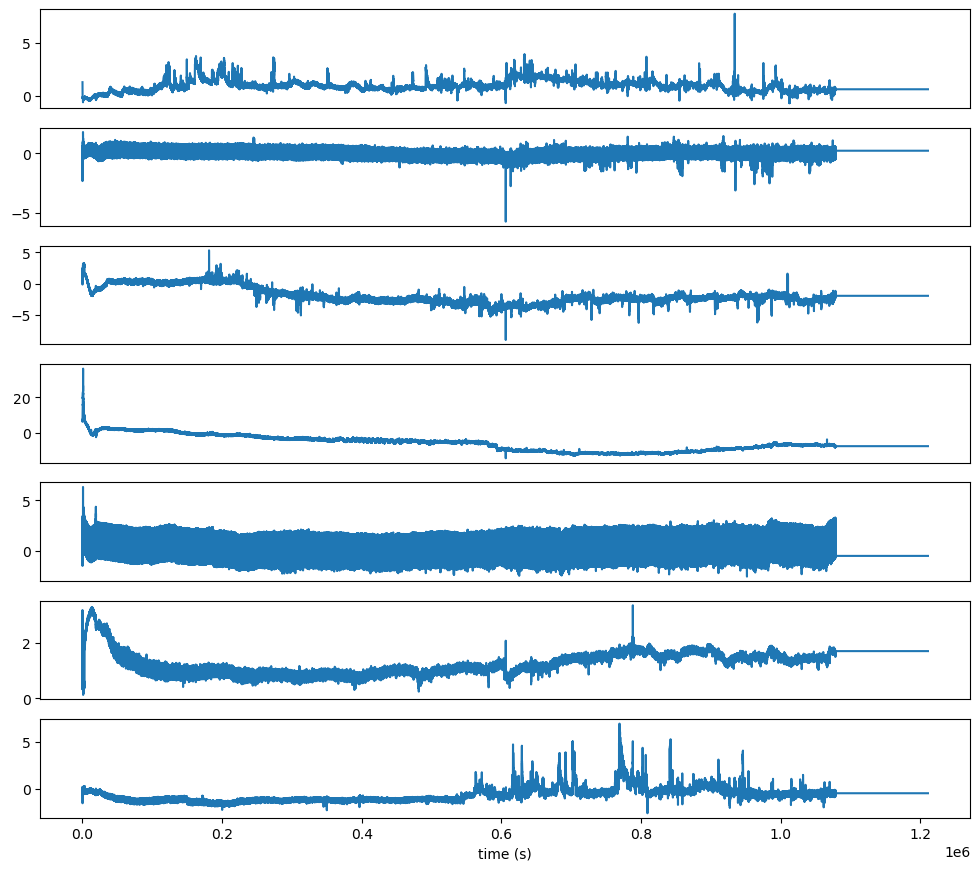

In [65]:
# plot each channel
time = np.arange(len(data)) / FS

fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time, data.iloc[:, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

### detect spikes
apply low pass filter, find epochs above threshold

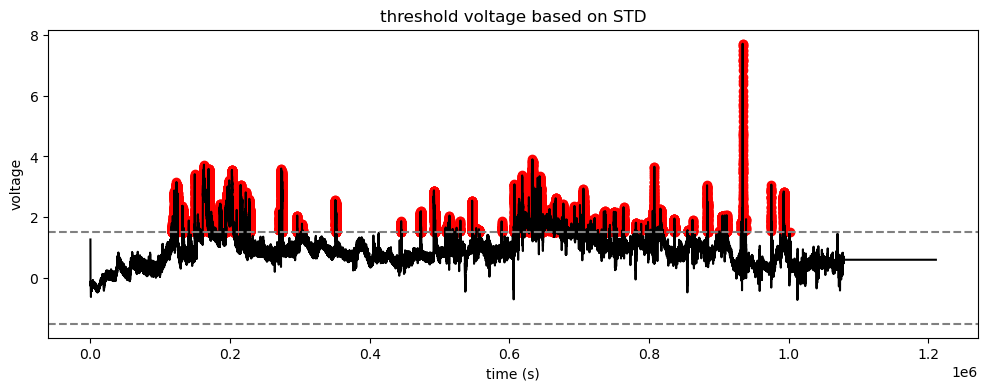

In [66]:
# simple threshold

# example cahnnel
i_chan = 0
sig = data.iloc[:, i_chan].values

# set threshold
thresh = np.std(sig) * 3

fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, sig, color='k')
ax.scatter(time[sig>thresh], sig[sig>thresh], color='r')
ax.scatter(time[sig<-thresh], sig[sig<-thresh], color='r')
ax.axhline(thresh, linestyle='--', color='grey')
ax.axhline(-thresh, linestyle='--', color='grey')
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("threshold voltage based on STD")
plt.show()

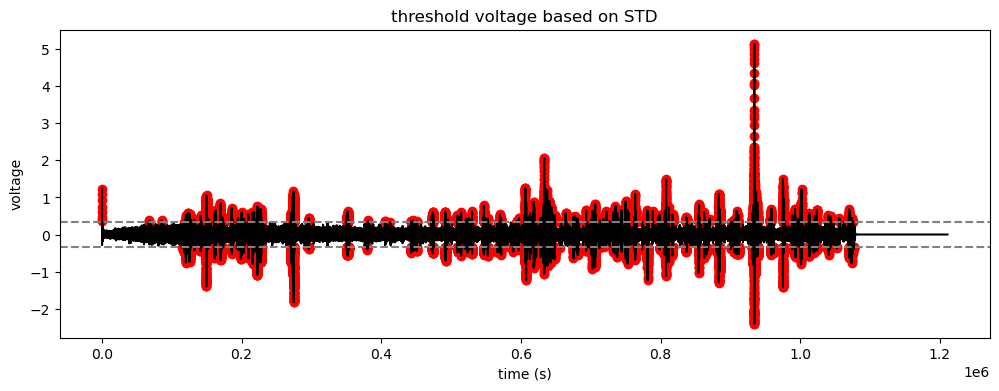

In [67]:
# highpass filter, then threshold

# filter signal
signal_filt = signal.sosfilt(signal.butter(10, 0.001, 'high', fs=FS, output='sos'), sig)

# set threshold
thresh = np.std(signal_filt) * 3

fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, signal_filt, color='k')
ax.scatter(time[signal_filt>thresh], signal_filt[signal_filt>thresh], color='r')
ax.scatter(time[signal_filt<-thresh], signal_filt[signal_filt<-thresh], color='r')
ax.axhline(thresh, linestyle='--', color='grey')
ax.axhline(-thresh, linestyle='--', color='grey')
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("threshold voltage based on STD")
plt.show()

Identified 1289 epochs
Joined 338 / 1289 epochs
Joined 1066 / 1290 epochs
Dropped 690 / 951 epochs
Dropped 14 / 224 epochs
Identified 1637 epochs
Joined 459 / 1637 epochs
Joined 1422 / 1637 epochs
Dropped 927 / 1178 epochs
Dropped 24 / 215 epochs


(<Figure size 2000x400 with 1 Axes>, <AxesSubplot:>)

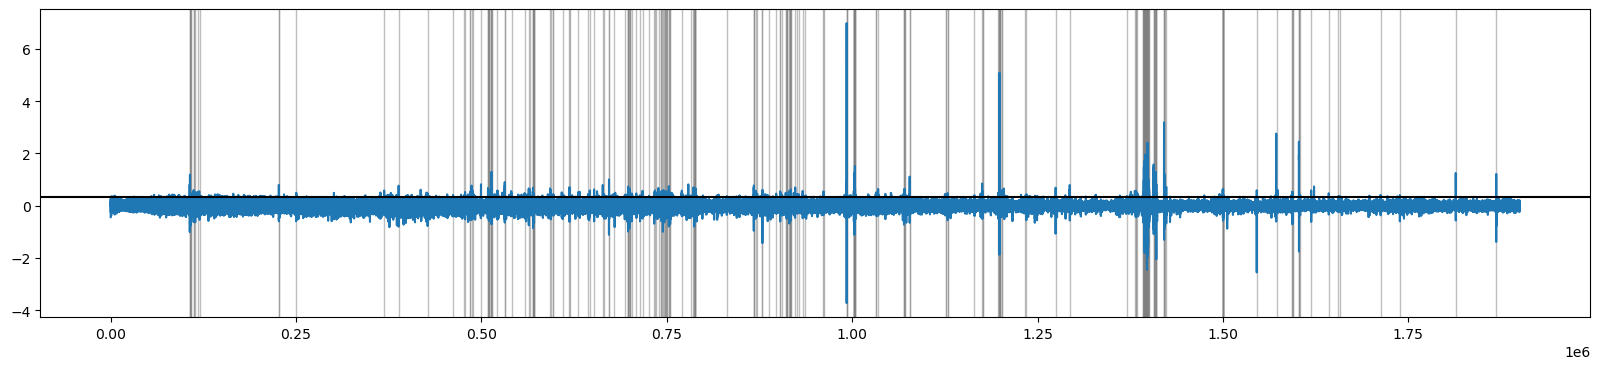

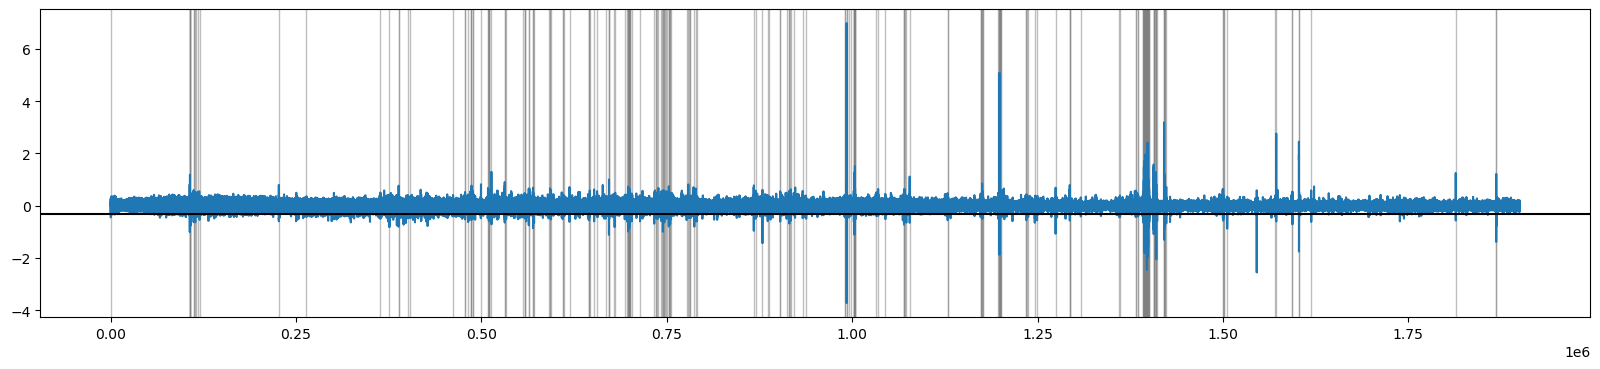

In [35]:
# find epochs
thresh = np.std(signal_filt) * 3
# epochs_pos = get_epochs(signal_filt, thresh)
# epochs_neg = get_epochs(-signal_filt, thresh)
epochs_pos,_ = get_epoch_times(signal_filt, thresh, min_gap=10, min_duration=10)
epochs_neg,_ = get_epoch_times(-signal_filt, thresh, min_gap=10, min_duration=10)

# plot
plot_epochs(signal_filt, time, epochs_pos, thresh)
plot_epochs(signal_filt, time, epochs_neg, -thresh)

### Plot results

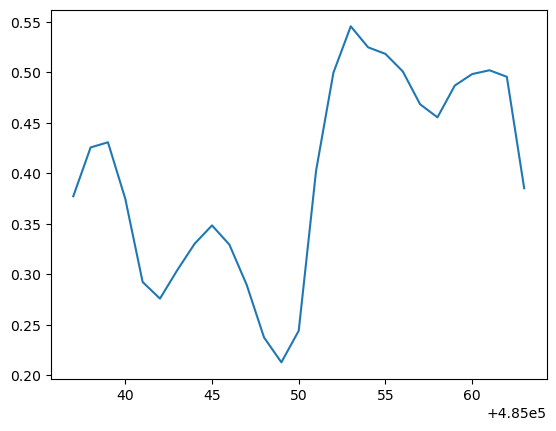

In [36]:
# plot example spikes
i_epoch = 19
plt.plot(time[epochs_pos[i_epoch][0]:epochs_pos[i_epoch][1]], signal_filt[epochs_pos[i_epoch][0]:epochs_pos[i_epoch][1]])

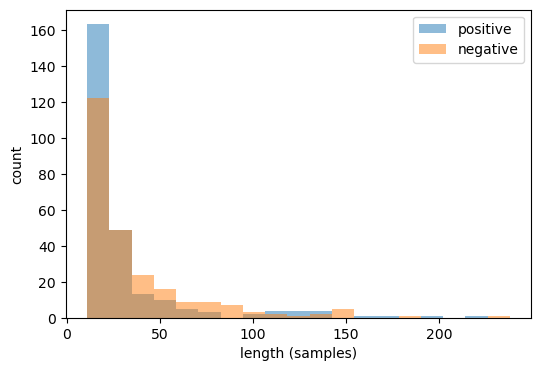

In [37]:
# compute duration of each spikes and plot histogram of results

# compute duration
lengths_pos = [epoch[1]-epoch[0] for epoch in epochs_pos]
lengths_neg = [epoch[1]-epoch[0] for epoch in epochs_neg]

# plot results
fig, ax = plt.subplots(1,1, figsize=[6,4])
all_values = np.concatenate([lengths_pos, lengths_neg])
bin_edges = np.linspace(np.min(all_values), np.max(all_values), 20)
ax.hist(lengths_pos, bin_edges, alpha=0.5, label='positive')
ax.hist(lengths_neg, bin_edges, alpha=0.5, label='negative')
ax.set(xlabel="length (samples)", ylabel="count")
ax.legend()
plt.show()

plotting 240 samples


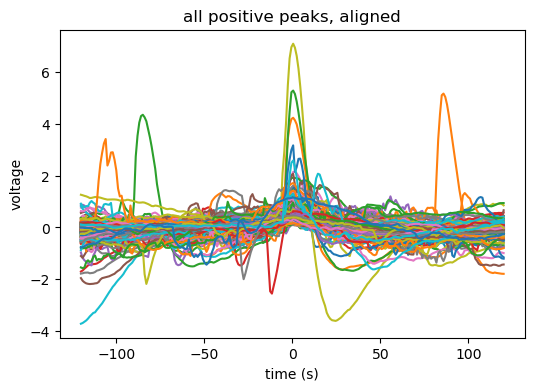

In [38]:
# plot all positive spikes, aligned at peak

# n_samples = int(np.median(lengths_pos))
# n = np.floor(n_samples/2)
n = 120
print(f"plotting {int(n*2)} samples")

# find peak of each spikes
peak_idx = []
for i_epoch, epoch in enumerate(epochs_pos):
    peak_idx.append(epoch[0] + np.argmax(signal_filt[epoch[0]:epoch[1]]))

# get signal around peak
peaks_array = np.zeros([len(peak_idx), int(n*2)])
for i_peak, idx in enumerate(peak_idx):
    if idx-n < 0: continue
    peaks_array[i_peak] = signal_filt[int(idx-n):int(idx+n)]

# subtract mean
peaks_array_bl = np.zeros_like(peaks_array)
for ii in range(len(peaks_array)):
    peaks_array_bl[ii] = peaks_array[ii] - np.mean(peaks_array[ii])

# plot
time_peak = np.linspace(-n*FS, n*FS, peaks_array.shape[1])
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time_peak, peaks_array_bl.T)
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("all positive peaks, aligned")
plt.show() 

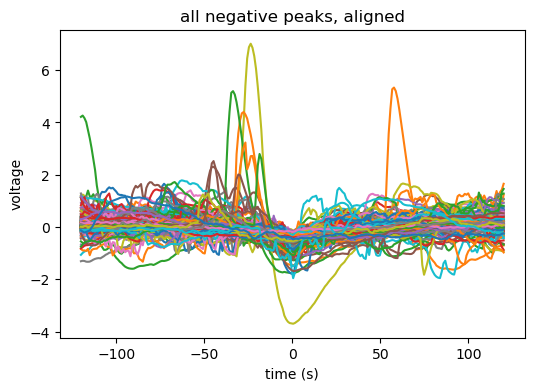

In [39]:
# plot all negative spikes

# find peak of each spikes
peak_idx = []
for i_epoch, epoch in enumerate(epochs_neg):
    peak_idx.append(epoch[0] + np.argmin(signal_filt[epoch[0]:epoch[1]]))
peak_idx

# get data
peaks_array = np.zeros([len(peak_idx), int(n*2)])
for i_peak, idx in enumerate(peak_idx):
    if idx-n < 0: continue
    peaks_array[i_peak] = signal_filt[int(idx-n):int(idx+n)]

# subtract mean
peaks_array_bl = np.zeros_like(peaks_array)
for ii in range(len(peaks_array)):
    peaks_array_bl[ii] = peaks_array[ii] - np.mean(peaks_array[ii])

# plot
time_peak = np.linspace(-n*FS, n*FS, peaks_array.shape[1])
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time_peak, peaks_array_bl.T)
ax.set(xlabel="time (s)", ylabel="voltage")
ax.set_title("all negative peaks, aligned")
plt.show() 

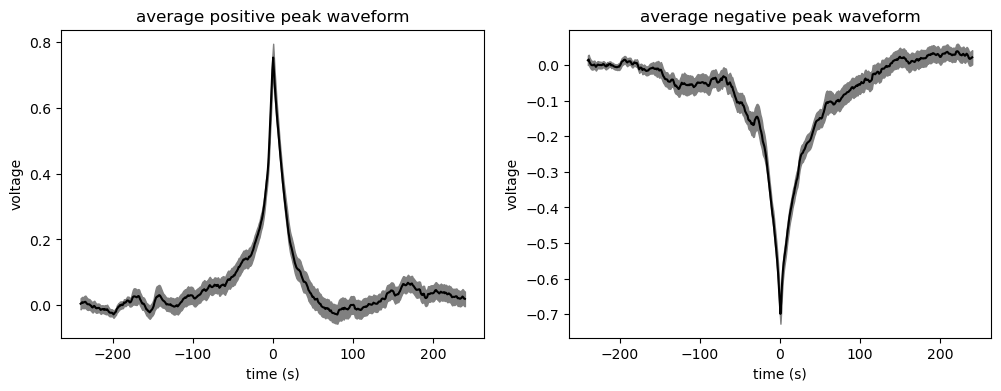

In [40]:
# plot avergae waveform for positive and negative spikes

n = 240

# find peak of each spikes
idx_n = []
for i_epoch, epoch in enumerate(epochs_neg):
    idx_n.append(epoch[0] + np.argmin(signal_filt[epoch[0]:epoch[1]]))
idx_p = []
for i_epoch, epoch in enumerate(epochs_pos):
    idx_p.append(epoch[0] + np.argmax(signal_filt[epoch[0]:epoch[1]]))

# get data
array_p = np.zeros([len(idx_p), int(n*2)])
for i_peak, idx in enumerate(idx_p):
    if idx-n < 0: continue
    array_p[i_peak] = signal_filt[int(idx-n):int(idx+n)]
array_n = np.zeros([len(idx_n), int(n*2)])
for i_peak, idx in enumerate(idx_n):
    if idx-n < 0: continue
    array_n[i_peak] = signal_filt[int(idx-n):int(idx+n)]

# subtract mean
for ii in range(len(array_p)):
    array_p[ii] = array_p[ii] - np.mean(array_p[ii, :int(n/3)])
for ii in range(len(array_n)):
    array_n[ii] = array_n[ii] - np.mean(array_n[ii, :int(n/3)])

# plot
time_peak = np.linspace(-n*FS, n*FS, array_p.shape[1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
for ax, array, tag in zip([ax1, ax2], [array_p, array_n], 
                            ['positive', 'negative']):
    mean = np.mean(array, axis=0)
    sem = np.std(array, axis=0) / np.sqrt(array.shape[0])
    ax.fill_between(time_peak, mean-sem, mean+sem, color='grey')
    ax.plot(time_peak, mean, color='k')
    ax.set(xlabel="time (s)", ylabel="voltage")
    ax.set_title(f"average {tag} peak waveform")
plt.show() 

In [41]:
# compute some quick spike stats
all_peaks = np.sort(np.concatenate([idx_p, idx_n]))
n_spikes = len(all_peaks)
spike_rate = n_spikes / time[-1]
isi = np.diff(all_peaks) / FS
mean_isi = np.mean(isi)
mean_duration = np.mean(np.concatenate([lengths_pos, lengths_neg])) * FS

print(f"Total number of spikes: \t{n_spikes}")
print(f"Mean duration: \t\t\t{mean_duration:0.2f} seconds")
print(f"Mean inter-spike interval: \t{mean_isi:.0f} seconds (i.e. {mean_isi/60:0.2f} minutes)")

Total number of spikes: 	512
Mean duration: 			32.84 seconds
Mean inter-spike interval: 	3655 seconds (i.e. 60.92 minutes)


In [70]:
# plot avergae waveform for positive and negative spikes

def analyze_spiking(sig, n=240, threshold=3, plot=False, print=False):
    # filter signal
    signal_filt = signal.sosfilt(signal.butter(10, 0.001, 'high', fs=FS, 
                                               output='sos'), sig)

    # find epochs
    signal_filt_ = signal_filt[~np.isnan(signal_filt)]
    thresh = np.std(signal_filt_) * threshold
    epochs_pos,_ = get_epoch_times(signal_filt, thresh, min_gap=0, 
                                    min_duration=0)
    epochs_neg,_ = get_epoch_times(-signal_filt, thresh, min_gap=0,
                                     min_duration=0)

    # find peak of each spikes
    idx_n = []
    for epoch in epochs_neg:
        idx_n.append(epoch[0] + np.argmin(signal_filt[epoch[0]:epoch[1]]))
    idx_p = []
    for epoch in epochs_pos:
        idx_p.append(epoch[0] + np.argmax(signal_filt[epoch[0]:epoch[1]]))

    # get data
    array_p = np.zeros([len(idx_p), int(n*2)])
    for i_peak, idx in enumerate(idx_p):
        if idx-n < 0: continue
        array_p[i_peak] = signal_filt[int(idx-n):int(idx+n)]
    array_n = np.zeros([len(idx_n), int(n*2)])
    for i_peak, idx in enumerate(idx_n):
        if idx-n < 0: continue
        array_n[i_peak] = signal_filt[int(idx-n):int(idx+n)]

    # subtract mean
    for ii in range(len(array_p)):
        array_p[ii] = array_p[ii] - np.mean(array_p[ii, :int(n/3)])
    for ii in range(len(array_n)):
        array_n[ii] = array_n[ii] - np.mean(array_n[ii, :int(n/3)])

    # plot
    if plot:
        time_peak = np.linspace(-n*FS, n*FS, array_p.shape[1])
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
        for ax, array, tag in zip([ax1, ax2], [array_p, array_n], 
                                    ['positive', 'negative']):
            mean = np.mean(array, axis=0)
            sem = np.std(array, axis=0) / np.sqrt(array.shape[0])
            ax.fill_between(time_peak, mean-sem, mean+sem, color='grey')
            ax.plot(time_peak, mean, color='k')
            ax.set(xlabel="time (s)", ylabel="voltage")
            ax.set_title(f"average {tag} peak waveform")
        plt.show() 

    # compute some quick spike stats
    all_peaks = np.sort(np.concatenate([idx_p, idx_n]))
    n_spikes = len(all_peaks)
    mean_isi = np.nanmean(np.diff(all_peaks) / FS)
    lengths_pos = [epoch[1]-epoch[0] for epoch in epochs_pos]
    lengths_neg = [epoch[1]-epoch[0] for epoch in epochs_neg]
    mean_duration = np.nanmean(np.concatenate([lengths_pos, lengths_neg])) * FS

    #  print results
    if print:
        print(f"Total number of spikes: \t{n_spikes}")
        print(f"Mean duration: \t\t\t{mean_duration:0.2f} seconds")
        print(f"Mean inter-spike interval: \t{mean_isi:.0f} seconds (i.e. {mean_isi/60:0.2f} minutes)")

    # return array_p, array_n
    return n_spikes, mean_duration, mean_isi


In [71]:
# analyze spking for all files and channels

# import
path = '../../../datasets/adamatzky_2021/txt'
files = os.listdir(path)

# loop over all files
df_list = []
for i_file, fname in enumerate(files):
    # display
    species = fname.split('.')[0]
    print(f"\n-------------{species}-------------")

    # load data and interpolate nan
    data = data.interpolate(method='linear', axis=0)
    data = pd.read_csv(os.path.join(path, fname), sep='\t')

    # analyze each channel
    for i_chan in range(N_CHANNELS):
        sig = data.iloc[:, i_chan].values
        n_spikes, mean_duration, mean_isi = analyze_spiking(sig)

        # aggregate results
        results = {'species': species, 'channel': i_chan, 
                    'n_spikes': n_spikes, 'mean_duration': mean_duration, 
                    'mean_isi': mean_isi}
        df_i = pd.DataFrame(results, index=[0])
        df_list.append(df_i)

df = pd.concat(df_list, ignore_index=True)
df


-------------cordyceps_militari-------------
Identified 1007 epochs
Joined 0 / 1007 epochs
Joined 0 / 1008 epochs
Dropped 289 / 1007 epochs
Dropped 0 / 1008 epochs
Identified 1311 epochs
Joined 0 / 1311 epochs
Joined 0 / 1311 epochs
Dropped 356 / 1311 epochs
Dropped 0 / 1311 epochs
Identified 928 epochs
Joined 0 / 928 epochs
Joined 0 / 929 epochs
Dropped 217 / 928 epochs
Dropped 0 / 929 epochs
Identified 921 epochs
Joined 0 / 921 epochs
Joined 0 / 921 epochs
Dropped 205 / 921 epochs
Dropped 0 / 921 epochs
Identified 107 epochs
Joined 0 / 107 epochs
Joined 0 / 107 epochs
Dropped 24 / 107 epochs
Dropped 0 / 107 epochs
Identified 99 epochs
Joined 0 / 99 epochs
Joined 0 / 100 epochs
Dropped 12 / 99 epochs
Dropped 0 / 100 epochs
Identified 199 epochs
Joined 0 / 199 epochs
Joined 0 / 199 epochs
Dropped 68 / 199 epochs
Dropped 0 / 199 epochs
Identified 143 epochs
Joined 0 / 143 epochs
Joined 0 / 144 epochs
Dropped 48 / 143 epochs
Dropped 0 / 144 epochs
Identified 523 epochs
Joined 0 / 523 ep

C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:57: RuntimeWarning: Mean of empty slice
  mean_isi = np.nanmean(np.diff(all_peaks) / FS)
C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:60: RuntimeWarning: Mean of empty slice
  mean_duration = np.nanmean(np.concatenate([lengths_pos, lengths_neg])) * FS


Identified 12 epochs
Joined 0 / 12 epochs
Joined 0 / 13 epochs
Dropped 4 / 12 epochs
Dropped 0 / 13 epochs
Identified 11 epochs
Joined 0 / 11 epochs
Joined 0 / 12 epochs
Dropped 9 / 11 epochs
Dropped 0 / 12 epochs
Identified 23 epochs
Joined 0 / 23 epochs
Joined 0 / 24 epochs
Dropped 6 / 23 epochs
Dropped 0 / 24 epochs

-------------ghost_fungi_omphalotus_nidiformis-------------
Identified 63 epochs
Joined 0 / 63 epochs
Joined 0 / 64 epochs
Dropped 42 / 63 epochs
Dropped 0 / 64 epochs
Identified 38 epochs
Joined 0 / 38 epochs
Joined 0 / 39 epochs
Dropped 24 / 38 epochs
Dropped 0 / 39 epochs
Identified 47 epochs
Joined 0 / 47 epochs
Joined 0 / 48 epochs
Dropped 13 / 47 epochs
Dropped 0 / 48 epochs
Identified 67 epochs
Joined 0 / 67 epochs
Joined 0 / 67 epochs
Dropped 23 / 67 epochs
Dropped 0 / 67 epochs
Identified 55 epochs
Joined 0 / 55 epochs
Joined 0 / 56 epochs
Dropped 9 / 55 epochs
Dropped 0 / 56 epochs
Identified 51 epochs
Joined 0 / 51 epochs
Joined 0 / 51 epochs
Dropped 7 / 51 e

C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:57: RuntimeWarning: Mean of empty slice
  mean_isi = np.nanmean(np.diff(all_peaks) / FS)
C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:60: RuntimeWarning: Mean of empty slice
  mean_duration = np.nanmean(np.concatenate([lengths_pos, lengths_neg])) * FS


Identified 46 epochs
Joined 0 / 46 epochs
Joined 0 / 46 epochs
Dropped 2 / 46 epochs
Dropped 0 / 46 epochs
Identified 44 epochs
Joined 0 / 44 epochs
Joined 0 / 45 epochs
Dropped 11 / 44 epochs
Dropped 0 / 45 epochs

-------------schizophyllum_commune-------------
Identified 1 epochs
Joined 1 / 1 epochs
Joined 1 / 1 epochs
Identified 10 epochs
Joined 0 / 10 epochs
Joined 0 / 10 epochs
Dropped 2 / 10 epochs
Dropped 0 / 10 epochs
Identified 16 epochs
Joined 0 / 16 epochs
Joined 0 / 17 epochs
Dropped 3 / 16 epochs
Dropped 0 / 17 epochs
Identified 98 epochs
Joined 0 / 98 epochs
Joined 0 / 98 epochs
Dropped 28 / 98 epochs
Dropped 0 / 98 epochs
Identified 74 epochs
Joined 0 / 74 epochs
Joined 0 / 75 epochs
Dropped 17 / 74 epochs
Dropped 0 / 75 epochs
Identified 5 epochs
Joined 0 / 5 epochs
Joined 0 / 5 epochs
Dropped 1 / 5 epochs
Dropped 0 / 5 epochs
Identified 5 epochs
Joined 0 / 5 epochs
Joined 0 / 6 epochs
Dropped 0 / 5 epochs
Dropped 0 / 6 epochs
Identified 8 epochs
Joined 0 / 8 epochs
Jo

C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:57: RuntimeWarning: Mean of empty slice
  mean_isi = np.nanmean(np.diff(all_peaks) / FS)
C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:60: RuntimeWarning: Mean of empty slice
  mean_duration = np.nanmean(np.concatenate([lengths_pos, lengths_neg])) * FS
c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\micha\anaconda3\envs\voytek_lab\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\micha\AppData\Local\Temp\ipykernel_86328\3702593332.py:57: 

,species,channel,n_spikes,mean_duration,mean_isi
0,cordyceps_militari,0,1673,5.845188,773.843900
1,cordyceps_militari,1,1427,6.017519,866.190042
2,cordyceps_militari,2,170,4.076471,7607.816568
3,cordyceps_militari,3,226,5.845133,5386.324444
4,cordyceps_militari,4,881,13.145289,1443.927273
5,cordyceps_militari,5,685,21.654015,1889.305556
6,cordyceps_militari,6,1240,6.970161,1015.313963
7,enoki_fungi_flammulina_velutipes,0,62,4.080645,888.475410
8,enoki_fungi_flammulina_velutipes,1,8,3.875000,109.714286
9,enoki_fungi_flammulina_velutipes,2,24,5.666667,2346.695652
